In [1]:
%load_ext autoreload
%autoreload 2
!pwd
import os
import sys 
if os.path.abspath("../../../") not in sys.path:
    sys.path.append(os.path.abspath("../../../")) 

import os
# import networkx as nx
from rwtools.nemesis.latency_map.create_latency_map import *
from rwtools.nemesis.graph.nemesis_node import AbstractNemesisNode
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from rwtools.nemesis.graph.control_flow_graph import ControlFlowGraph



/home/gilles/git-repos/NemesisRetroWrite/retrowrite/rwtools/nemesis/evaluation_notebooks


# Load list of branching instructions
In the form of instruction addresses 


In [2]:
import json 

test_name = "fork"

input_binary = os.path.abspath(f"../test_programs/{test_name}/{test_name}")
output_assembly = os.path.abspath(f"../test_programs/{test_name}/{test_name}_rw.s")
output_binary = os.path.abspath(f"../test_programs/{test_name}/{test_name}_rw")
test_values = os.path.abspath(f"../test_programs/{test_name}/test_inputs.txt")

# instrument each function seperately 
First instrument the code, then dump the rewritten program, then compile into new binary using gcc 

[*] Relocations for a section that's not loaded: .rela.dyn
[*] Relocations for a section that's not loaded: .rela.plt
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3df0
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8


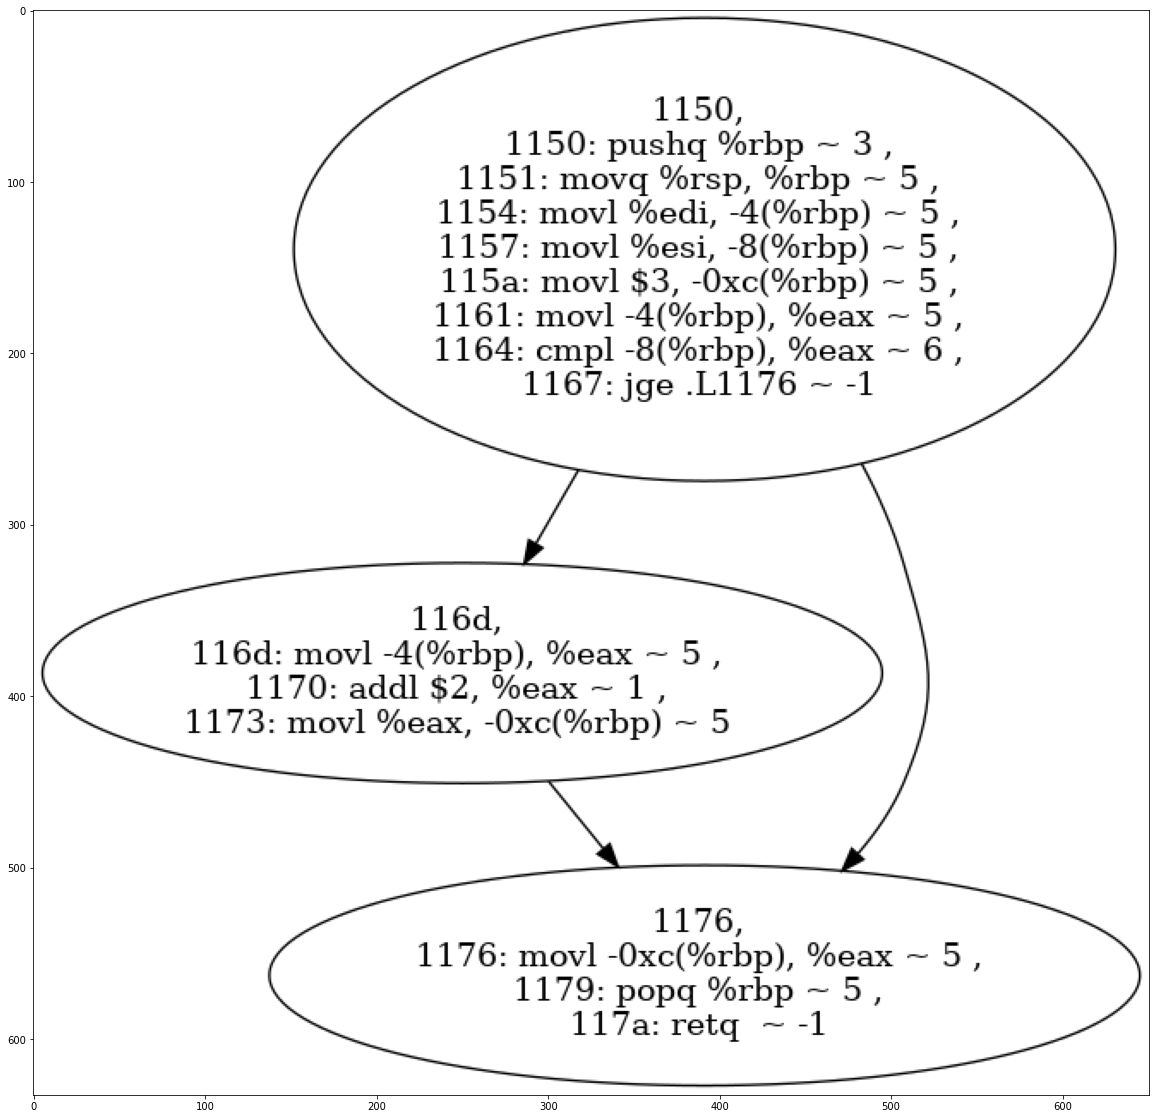

In [3]:
from rwtools.nemesis.nemesistool import NemesisInstrumentProgram
import subprocess 

tool = NemesisInstrumentProgram(input_binary, output_assembly)

func = tool.functions['fork']

figs, axs = plt.subplots(1, figsize=(20,20))
axs.imshow(func.render_cfg())

target_node = func.cfg.get_node("1150")
func.cfg.insert_nodes(target_node)




[*] Relocations for a section that's not loaded: .rela.dyn
[*] Relocations for a section that's not loaded: .rela.plt
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3df0
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8
fork
main


CompletedProcess(args=['gcc', '/home/gilles/git-repos/NemesisRetroWrite/retrowrite/rwtools/nemesis/test_programs/fork/fork_rw.s', '-o', '/home/gilles/git-repos/NemesisRetroWrite/retrowrite/rwtools/nemesis/test_programs/fork/fork_rw'], returncode=0)

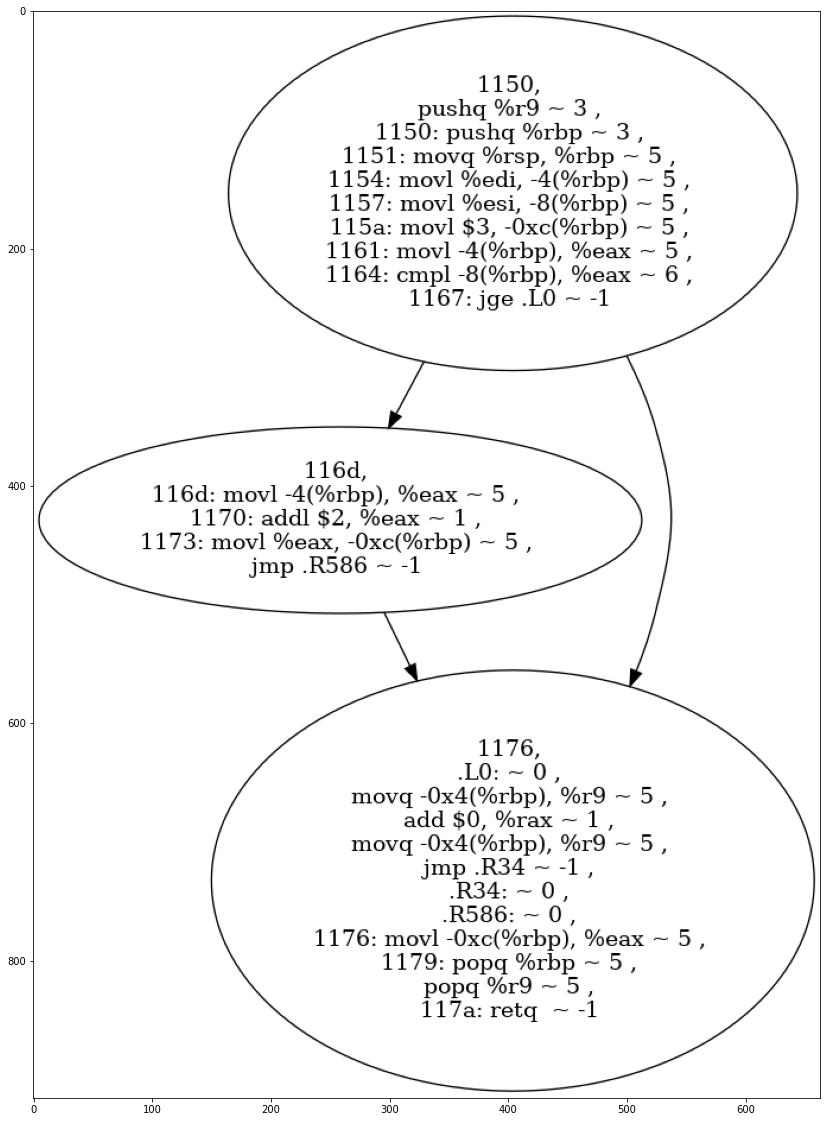

In [4]:
tool = NemesisInstrumentProgram(input_binary, output_assembly)
tool.instrument_program([1167])

figs, axs = plt.subplots(1, figsize=(20,20))
axs.imshow(tool.functions['fork'].render_cfg())
tool.dump()

subprocess.run(["gcc", output_assembly, "-o", output_binary])


[*] Relocations for a section that's not loaded: .rela.dyn
[*] Relocations for a section that's not loaded: .rela.plt
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3db8
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8
no issues found


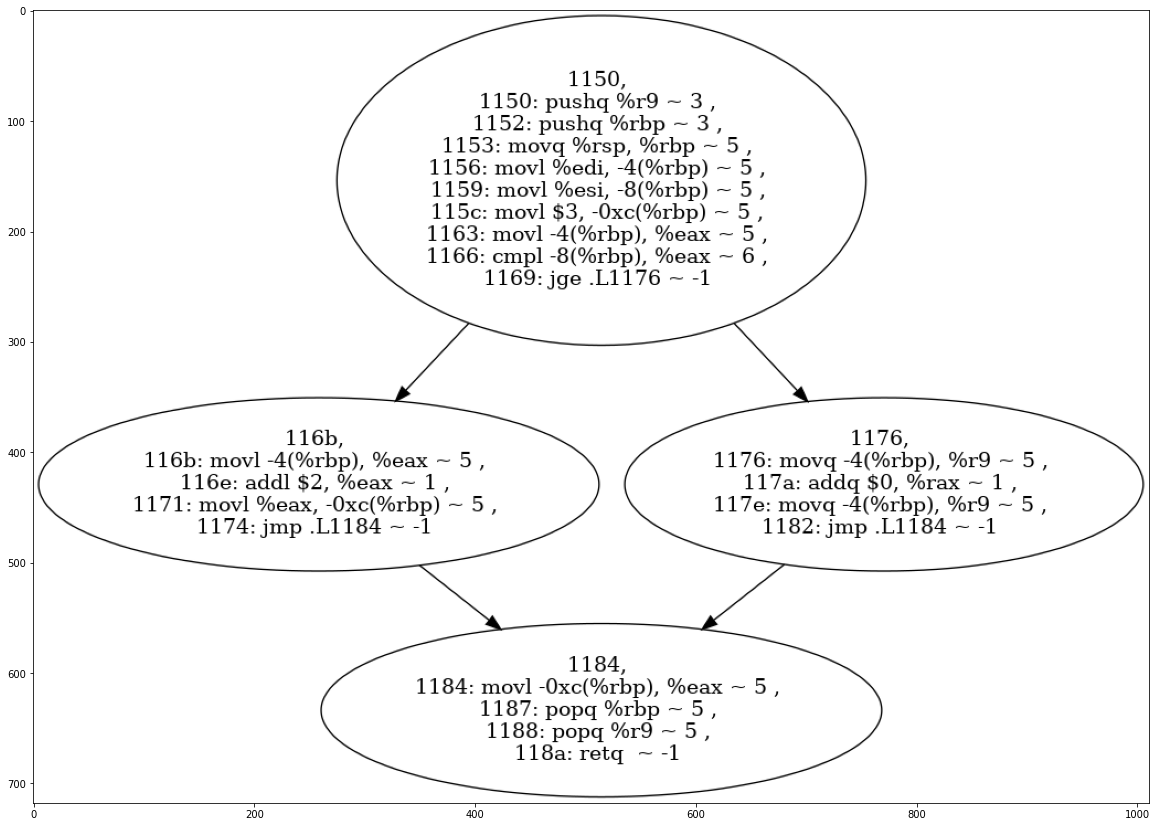

In [5]:
from rwtools.nemesis.evaluationtool import NemesisEvaluateProgram 
evaluation = NemesisEvaluateProgram(output_binary, "")

figs, axs = plt.subplots(1, figsize=(20,20))

evaluation.evaluate_program([1169])
axs.imshow(evaluation.functions['fork'].render_cfg())


In [6]:

test_cases = []

with open(test_values, "r") as f: 
    for line in f:
        test_cases.append(line.strip().split(" "))

for test_case in test_cases: 
    expected = subprocess.run([input_binary, *test_case]).returncode
    result = subprocess.run([output_binary, *test_case]).returncode
    if expected != result:
        print("incorrect result on test with inputs", *test_case)
    else: 
        print("correct")

correct
correct
correct
correct
correct
correct
correct


# Evaluate effect on runtime
Look at the number of cycles inserted per path   
Somehow map paths from the original to paths on the new node 
How? 

For a node 

[*] Relocations for a section that's not loaded: .rela.dyn
[*] Relocations for a section that's not loaded: .rela.plt
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3df0
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8
[*] Relocations for a section that's not loaded: .rela.dyn
[*] Relocations for a section that's not loaded: .rela.plt
[x] Could not replace value in .init_array
[x] Couldn't find valid section 3db8
[x] Couldn't find valid section 3fd8
[x] Couldn't find valid section 3fe0
[x] Couldn't find valid section 3fe8
[x] Couldn't find valid section 3ff0
[x] Couldn't find valid section 3ff8
evaluation: 
['1150', '116d', '1176'] 55 63
increase percentage: 1.15
['1150', '0', '1176'] 44 63
increase percentage: 1.43


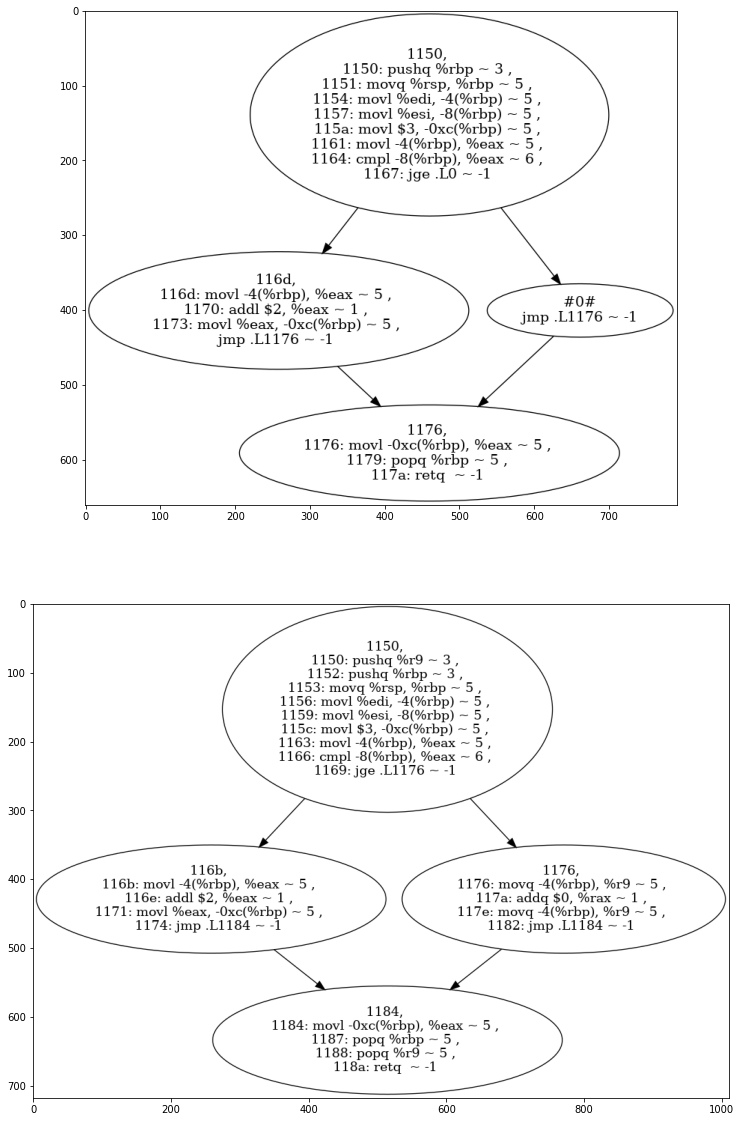

In [7]:
from rwtools.nemesis.evaluationtool import NemesisEvaluateProgram 

from networkx.algorithms.isomorphism import  is_isomorphic
from rwtools.nemesis.evaluationtool import mapping 
from rwtools.nemesis.graph.abstract_nemesis_node import flatten 
import networkx as nx
from rwtools.nemesis.evaluationtool import evaluate_runtime 

original = NemesisEvaluateProgram(input_binary, "")
modified = NemesisEvaluateProgram(output_binary, "")

# insert nodes so that the two graphs are isomorphic 
orig_func = original.functions["fork"]
target_node = orig_func.cfg.get_node('1150')
orig_func.cfg.insert_nodes(target_node)

modified_func = modified.functions['fork']

figs, axs = plt.subplots(2, figsize=(20,20))
axs[0].imshow(orig_func.render_cfg())
axs[1].imshow(modified_func.render_cfg())

print('evaluation: ')
results = evaluate_runtime(orig_func, modified_func)

for path, original, modified in results: 
    print([p.id for p in path], original, modified)
    print(f"increase percentage: {float(modified)/float(original):.2f}")
    